<a href="https://colab.research.google.com/github/najibutp/Machine-Vision/blob/main/MV_Quiz_3_Q3_Apparel_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler # for validation test
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from IPython.display import clear_output

In [2]:
apparel_desc = {
0: "T-shirt/top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"
}

In [3]:
# Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])
# mean and std have to be sequences (e.g tuples), therefore we should add a comma after the values

# Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

# Preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size = 32)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size = 32)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


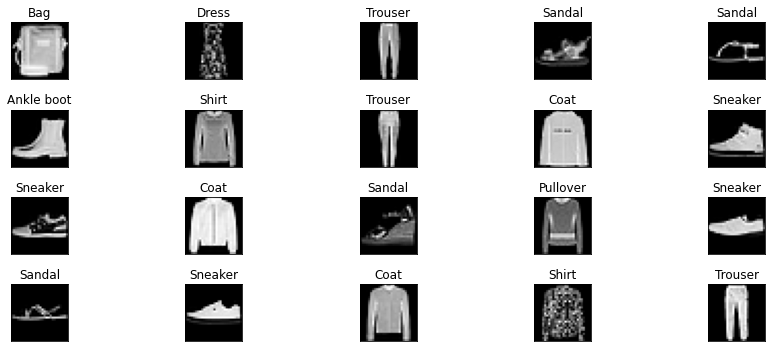

In [4]:
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()

fig = plt.figure(figsize = (15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  # np.squeeze : Remove single dimensional entries from the shape of an array
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # .item() gets the value contained in a Tensor
  ax.set_title(apparel_desc[labels[idx].item()])
  fig.tight_layout()

In [5]:
# Build the neural network, expand on top of nn.Module
class Classifier(nn.Module):
  def __init__(self):
      super(Classifier,self).__init__()

      # weights initialization
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
                
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0)

      # define layers
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=2, padding=11)
      #self.activ1 = nn.ELU(alpha=1.0)
      self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
      self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=4, stride=2, padding=3)
      #self.activ2 = nn.ELU(alpha=1.0)
      self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
      
      self.fc1 = nn.Linear(in_features=12*4*4, out_features=192)
      self.fc2 = nn.Linear(in_features=192, out_features=120)
      self.drop1 = nn.Dropout2d(1)
      self.fc3 = nn.Linear(in_features=120, out_features=60)
      self.fc4 = nn.Linear(in_features=60, out_features=10)


  # define forward function
  def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.pool1(x)
      
      x = self.conv2(x)
      x = F.relu(x)
      x = self.pool2(x)

      x = x.view(-1,12*4*4)

      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.drop1(x)
      x = self.fc3(x)
      x = F.relu(x)
      x = self.fc4(x)

      return x


        

In [6]:
model = Classifier()

# defining the loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

valid_loss_min = np.Inf # using this high value to make sure the update the weight first time
epochs = 50
steps = 0
model.train() # prep model for training
train_losses, valid_losses = [],[]
train_accuracies, valid_accuracies = [],[]
epoch_start_time = None
run_start_time = None
run_start_time = time.time()
run_data = []
run_params = None

for e in range(epochs):
  running_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0
  epoch_start_time = time.time()

  # train the model #
  for images, labels in trainloader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*images.size(0) # images.size(0) is the batch size
    #train_acc += log_ps*images.size(0)

    # Compute the accuracy
    ret, predictions = torch.max(log_ps.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
            
    # Convert correct_counts to float and then compute the mean
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
    # Compute total accuracy in the whole batch and add to train_acc
    train_acc += acc.item() * images.size(0)
  
  # Validation - No gradient tracking needed
  with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)
        
        # Compute the accuracy
        ret, predictions = torch.max(log_ps.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
            
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
        # Compute total accuracy in the whole batch and add to train_acc
        valid_acc += acc.item() * images.size(0)
  
  running_loss = running_loss / len(trainloader.sampler)
  valid_loss = valid_loss / len(validloader.sampler)
  epoch_duration = time.time() - epoch_start_time
  run_duration = time.time() - run_start_time

  # Find average training and validation accuracy
  avg_train_acc = train_acc/len(trainloader.sampler)
  avg_valid_acc = valid_acc/len(validloader.sampler)


  #train_acc = train_acc / len(trainloader.sampler)
  #valid_acc = valid_acc / len(validloader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(avg_train_acc)
  valid_accuracies.append(avg_valid_acc)

  # Write into 'results' (OrderedDict) for all run related data
  results = OrderedDict()
  results["Epoch"] = e+1
  results["Training Loss"] = running_loss
  results["Validation Loss"] = valid_loss
  results["Training Accuracy"] = avg_train_acc
  results["Validation Accuracy"] = avg_valid_acc
  results["Epoch Duration"] = epoch_duration
  results["Run Duration"] = run_duration

  run_data.append(results)
  df = pd.DataFrame.from_dict(run_data, orient = 'columns')

  # display epoch information and show progress
  clear_output(wait=True)
  display(df)

  if valid_loss <= valid_loss_min:
    print('validation loss decreased({:.6f} --> {:.6f}), Saving Model ...'.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

,Epoch,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Epoch Duration,Run Duration
0,1,2.304027,2.301651,0.099500,0.099646,15.816878,15.817243
1,2,1.684525,1.090548,0.353583,0.544333,15.096400,30.946565
2,3,0.811277,0.671612,0.687500,0.743292,14.999351,45.962681
3,4,0.628090,0.579307,0.762000,0.784937,15.053289,61.038107
4,5,0.560745,0.581698,0.787083,0.777979,15.099262,76.157671
5,6,0.527998,0.509329,0.800250,0.814792,15.006738,91.181200
6,7,0.493737,0.523485,0.815500,0.810667,15.020019,106.219805
7,8,0.474731,0.470534,0.822833,0.828083,14.974435,121.209273
8,9,0.457178,0.445584,0.828083,0.836583,14.886930,136.113259
9,10,0.436777,0.487734,0.836000,0.816083,14.909872,151.040461


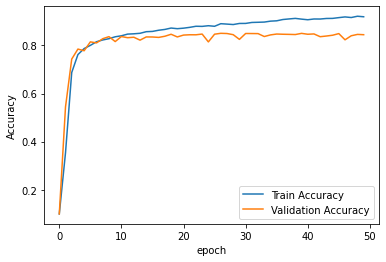

In [7]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')

plt.xlabel("epoch")
plt.ylabel("Accuracy")

plt.legend()

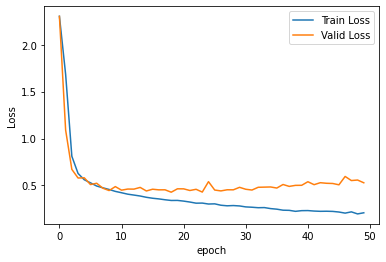

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.legend()

In [9]:
# track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testloader:
  # forward pass
  output = model(images)
  # calculate the loss
  loss = criterion(output, labels)
  # update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output,1)
  # compare predictions to the true labels
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  # calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# calculate and print test loss
test_loss = test_loss / len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)'% class_total[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.564184

Test Accuracy of     0: 76% (763/1000)
Test Accuracy of     1: 95% (950/1000)
Test Accuracy of     2: 64% (644/1000)
Test Accuracy of     3: 86% (860/1000)
Test Accuracy of     4: 78% (787/1000)
Test Accuracy of     5: 95% (958/1000)
Test Accuracy of     6: 56% (569/1000)
Test Accuracy of     7: 94% (944/1000)
Test Accuracy of     8: 94% (949/1000)
Test Accuracy of     9: 92% (921/1000)

Test Accuracy (Overall): 83% (8345/10000)


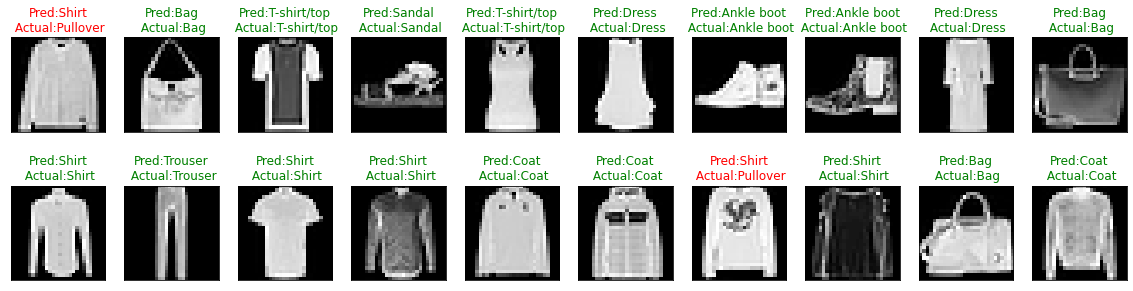

In [14]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize = (20,5))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("Pred:{}\n Actual:{}".format(str(apparel_desc[preds[idx].item()]), str(apparel_desc[labels[idx].item()])), color=('green' if preds[idx]==labels[idx] else 'red'))